# **Toxic Comment Classification Challenge**

### **1. Descripção do problema**

 Em várias plataformas de mídia social, as seçães de comentários permitem que os usuários
 compartilhem ideias e discutam diferentes pontos de vista. No entanto, há um abuso
 de linguagem tóxica, especialmente no X (antigo Twitter), que não tem regras rígidas
 para regular esse tipo de comentário, o que está afetando a qualidade dessas conversas.
 Comentários que incluem ameaças, insultos, linguagem vulgar ou ódio contra certos gru
 pos sociais, dificultando um diálogo saudável.

### **2. Análise descritiva de cada atributo**

### **Importação de biblioteca e carregamento de dados**

In [1]:
# Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re
import string
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from textstat import flesch_reading_ease
import warnings
warnings.filterwarnings("ignore")

# Carregando os dados
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [2]:
# Adicionar a coluna length (número de palavras no comentário)
train['length'] = train['comment_text'].apply(lambda x: len(str(x).split()))

# Adicionar a coluna flesch_scaler (índice de legibilidade)
train['flesch_scaler'] = train['comment_text'].apply(lambda x: flesch_reading_ease(str(x)))

# Adicionar a coluna length (número de palavras no comentário)
test['length'] = test['comment_text'].apply(lambda x: len(str(x)))

# Adicionar a coluna flesch_scaler (índice de legibilidade)
test['flesch_scaler'] = test['comment_text'].apply(lambda x: flesch_reading_ease(str(x)))
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,flesch_scaler
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,43,66.370388
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,17,73.795735
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,42,65.725000
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,113,51.112030
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,13,89.606731


#### **a) Identificar os tipos de atributos**

A identificação dos tipos de atributos consiste em classificar cada coluna do dataset conforme sua natureza: **nominal**, **ordinal**, **binário**, **contínuo** ou **discreto**.

<center>

| Coluna | Tipo de Atributo | Descrição |
|-----------|-----------|---------------|
| id | Categórico nominai | Identificador único. <br>Não tem ordem nem significado além de identificar a fila |
| comment_text | Categórico nominai | Texto livre que contém o comentário a classificar.<br>Não team hierarquia nem ordem |
| toxic <br> severe_toxic <br> obscene <br> threat <br> insult<br> identity_hate| Binário assimétrico | 1 = Tóxico, 0 = Não Tóxico. <br> A classe positiva (1) é menos frequente, pelo que é assimétrica |
| length         | Contínuo             | Número total de palavras no comentário.                                |
| flesch_scaler  | Contínuo             | Índice de legibilidade Flesch Reading Ease. Valores mais altos indicam maior facilidade de leitura. |


</center>

- **`id`** e **`comment_text`** são **atributos nominais**, não usados diretamente na modelagem.
- As etiquetas (**`toxic`**, **`severe_toxic`**, **`obscene`**, **`threat`**, **`insult`**, **`identity_hate`**.) são **binárias assimétricas**, importantes para prever comportamentos tóxicos.

Além das variáveis fornecidas no dataset original, foram adicionados dois novos atributos numéricos:

- **`length`**: representa o número de caracteres no comentário. Pode indicar complexidade, extensão ou ênfase do texto.
- **`flesch_scaler`**: mede a legibilidade do comentário com base no índice Flesch Reading Ease. Comentários mais simples tendem a ter pontuações mais altas.

#### **b) Para atributo numérico: análise descritiva e visualização**

Nesta etapa, devemos identificar para cada atributo numérico e não categorizado:

- Intervalo de valores (mínimo e máximo).

- Valor médio.

- Desvio-padrão.

- Possíveis valores aberrantes (outliers).


              length  flesch_scaler
count  159571.000000  159571.000000
mean       67.273527      60.118723
std        99.230702     128.131875
min         1.000000  -36681.810000
25%        17.000000      49.484853
50%        36.000000      63.176029
75%        75.000000      76.553333
max      1411.000000     134.080000


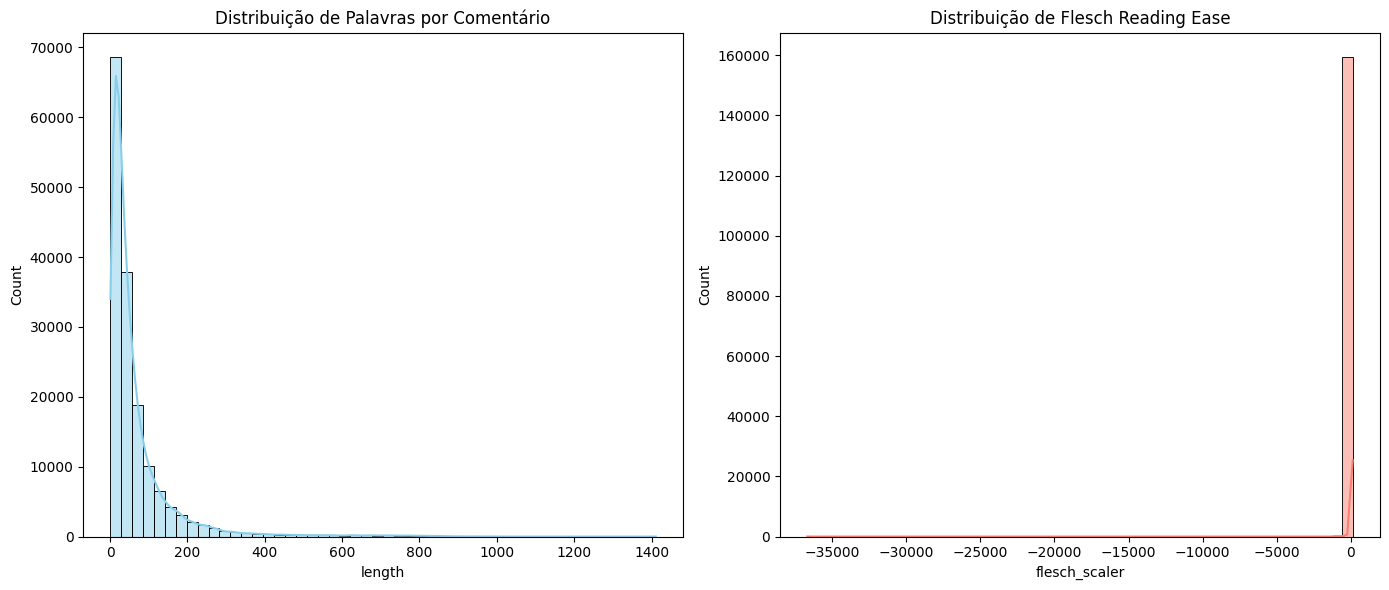

In [3]:
# Estatísticas descritivas
print(train[['length', 'flesch_scaler']].describe())

# Histograma
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(train['length'], bins=50, kde=True, color='skyblue')
plt.title('Distribuição de Palavras por Comentário')

plt.subplot(1, 2, 2)
sns.histplot(train['flesch_scaler'], bins=50, kde=True, color='salmon')
plt.title('Distribuição de Flesch Reading Ease')

plt.tight_layout()
plt.show()

**Lenght**
- A maioria dos comentários possui um comprimento curto (menor que 500 caracteres).
- A distribuição é assimétrica à direita (distribuição enviesada positivamente), com poucos comentários extremamente longos (outliers).
- Esse padrão é típico em dados de texto, pois a maioria dos comentários tende a ser breve.

**Flesch Reading Ease**
- A maioria dos valores está concentrada em torno de 0, com valores negativos extremos que indicam baixa legibilidade.
- Valores tão negativos sugerem possíveis erros na extração dos textos (ex: strings vazias ou mal formatadas).

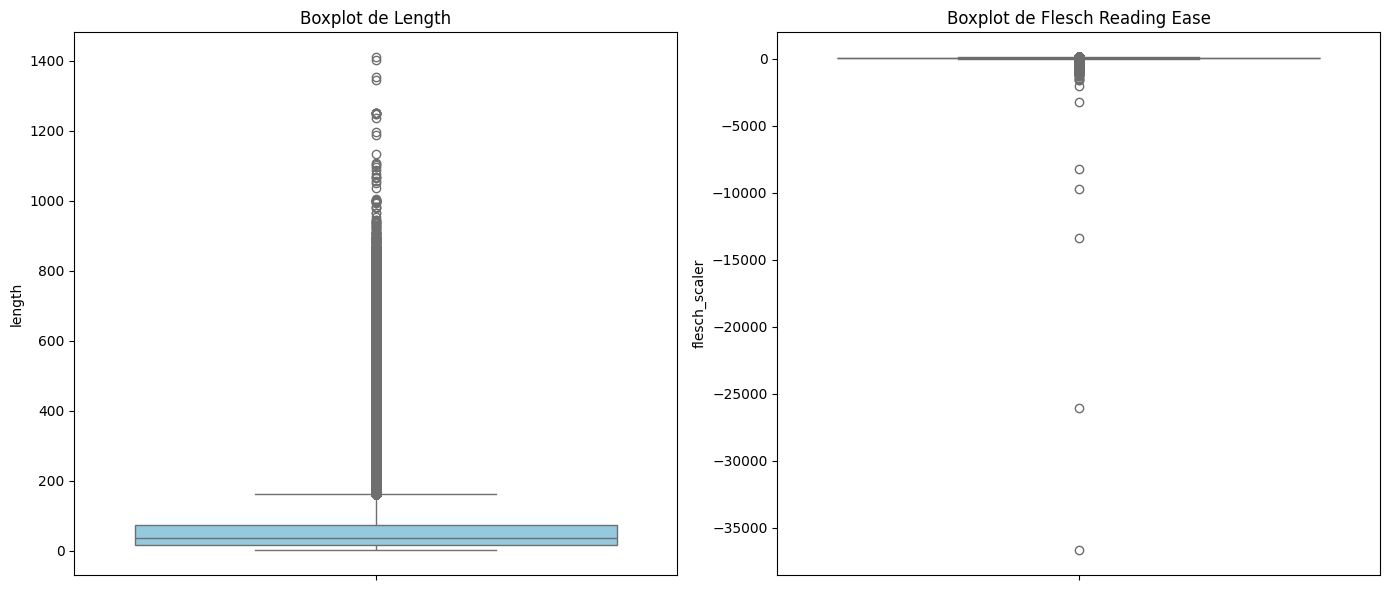

In [4]:
# Boxplots
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=train['length'], color='skyblue')
plt.title('Boxplot de Length')

plt.subplot(1, 2, 2)
sns.boxplot(y=train['flesch_scaler'], color='salmon')
plt.title('Boxplot de Flesch Reading Ease')

plt.tight_layout()
plt.show()

**Lenght**
- A mediana é visivelmente baixa, confirmando que a maioria dos comentários é curta.
- Existem vários **outliers** com comprimento significativamente maior que o terceiro quartil, sugerindo a necessidade de tratamento dependendo do modelo usado.

**Flesch Reading Ease**
- Há uma grande quantidade de outliers muito abaixo de 0, reforçando a suspeita de dados problemáticos.
- A dispersão é alta, o que indica que os comentários possuem uma variabilidade significativa em termos de facilidade de leitura.

### **c) Distribuição de valores e popularidade dos atributos**

Nesta etapa, para cada atributo **binário, nominal ou ordinal**, devemos:

- Identificar os **valores possíveis**.  
- Verificar a **popularidade** ou **frequência relativa** de cada valor (distribuição de probabilidade).

No nosso dataset, analisamos as **etiquetas binárias**: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult` e `identity_hate`.  
Para o atributo `comment_text` (nominal), não é viável analisar distribuição direta, mas podemos analisar o **comprimento** ou outras métricas.


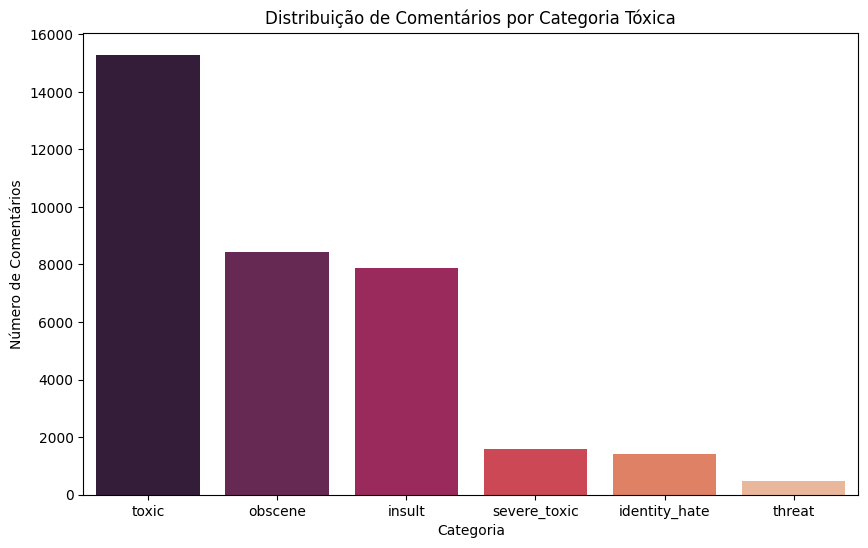

In [5]:
# Lista de columnas de etiquetas
bin_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Conteo absoluto por etiqueta
label_counts = train[bin_cols].sum().sort_values(ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="rocket")
plt.title('Distribuição de Comentários por Categoria Tóxica')
plt.ylabel('Número de Comentários')
plt.xlabel('Categoria')
plt.show()


Classe **"toxic"**:

- É de longe a mais frequente (~15.000 ocorrências).

- Isso sugere que se trata de um rótulo genérico que agrupa várias formas de toxicidade.

Classe **"Obscene"** e **"insult"**:

- São as segundas mais comuns (~8.000 e ~7.000 ocorrências, respectivamente).

- Indicam que insultos e linguagem obscena são frequentes no conjunto.

Classe **"severe_toxic"**, **"identity_hate"** e **"threat"**:

- São claramente sub-representadas, especialmente "threat" e "identity_hate", que apresentam pouquíssimas ocorrências (~1.000 ou menos).

- Isso introduz um problema de desequilíbrio de classes, que pode afetar o desempenho do modelo se não for tratado adequadamente.

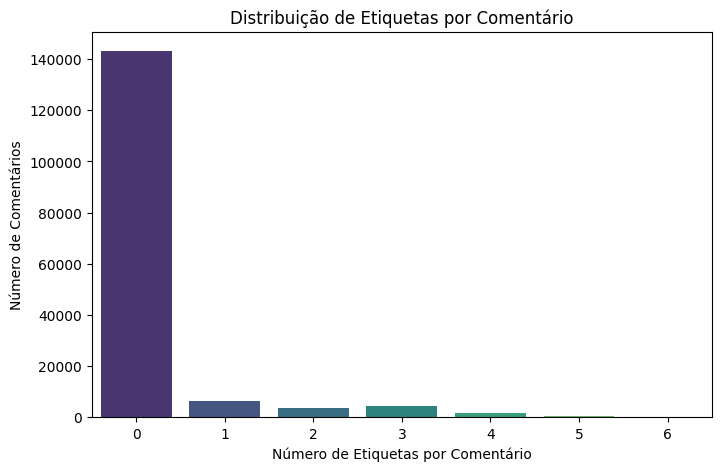

In [6]:
# Adicionar a coluna num_bin_cols
train['num_bin_cols'] = train[bin_cols].sum(axis=1)

# Distribuição de número de etiquetas por comentário
plt.figure(figsize=(8, 5))
sns.countplot(x='num_bin_cols', data=train, palette='viridis')
plt.title('Distribuição de Etiquetas por Comentário')
plt.xlabel('Número de Etiquetas por Comentário')
plt.ylabel('Número de Comentários')
plt.show()

- A maioria absoluta dos comentários (mais de **140.000**) **não possui nenhuma etiqueta tóxica**, ou seja, são comentários **não tóxicos**.
- Uma pequena fração dos comentários possui **exatamente 1 etiqueta** (ex: apenas `toxic` ou apenas `insult`).
- À medida que aumenta o número de etiquetas (2, 3, 4, 5, 6), a quantidade de comentários **cai drasticamente**, o que indica que:
  - Comentários com múltiplas formas de toxicidade são **raros**.
  - O problema é altamente **desbalanceado**.
- Isso reforça a natureza **multi-rótulo assimétrica** do dataset:  
  - Cada comentário pode ter **nenhuma, uma ou mais etiquetas** de toxicidade.
  - Mas a ocorrência conjunta de várias categorias é **muito incomum**.

### **d) Valores Ausentes, Aberrantes e Inconsistências**

Nesta etapa, devemos:

- Identificar **valores ausentes** (`NaN`, `None`) usando funções como `.isna()` ou `.isnull()`.  
- Verificar se há **valores aberrantes** (fora do esperado).  
- Detectar possíveis **inconsistências**, como registros duplicados ou valores fora do domínio esperado.


In [7]:
# 1. Valores ausentes
missing = train.isnull().sum().reset_index()
missing.columns = ['Coluna', 'Valores_ausentes']

# 2. Verificar valores únicos de dois atributos binários
unique_vals = pd.DataFrame({
    'Atributo': bin_cols,
    'Valores_únicos': [train[label].unique().tolist() for label in bin_cols]
})
# 3. Verificar registros duplicados
duplicados = train.duplicated().sum()

# 4. Verificar estatísticas das colunas numéricas
numeric_cols = ['length', 'flesch_scaler']
stats = train[numeric_cols].describe().T
stats['outliers_abaixo'] = (train[numeric_cols] < stats['mean'] - 3 * stats['std']).sum()
stats['outliers_acima']  = (train[numeric_cols] > stats['mean'] + 3 * stats['std']).sum()

# Mostrar tabelas
print("Valores ausentes:")
display(missing)

print("Valores únicos nos atributos binários:")
display(unique_vals)

print(f"Registros duplicados: {duplicados}")

print("Estatísticas e possíveis outliers nas variáveis numéricas:")
display(stats)



Valores ausentes:


,Coluna,Valores_ausentes
0,id,0
1,comment_text,0
2,toxic,0
3,severe_toxic,0
4,obscene,0
5,threat,0
6,insult,0
7,identity_hate,0
8,length,0
9,flesch_scaler,0


Valores únicos nos atributos binários:


,Atributo,Valores_únicos
0,toxic,"[0, 1]"
1,severe_toxic,"[0, 1]"
2,obscene,"[0, 1]"
3,threat,"[0, 1]"
4,insult,"[0, 1]"
5,identity_hate,"[0, 1]"


Registros duplicados: 0
Estatísticas e possíveis outliers nas variáveis numéricas:


,count,mean,std,min,25%,50%,75%,max,outliers_abaixo,outliers_acima
length,159571.0,67.273527,99.230702,1.00,17.000000,36.000000,75.000000,1411.00,0,3513
flesch_scaler,159571.0,60.118723,128.131875,-36681.81,49.484853,63.176029,76.553333,134.08,206,0


- Não foram encontrados valores ausentes em nenhuma das colunas, incluindo length e flesch_score.

- Os atributos binários contêm apenas os valores esperados: 0 e 1, sem inconsistências.

- Foram identificados alguns valores extremos (outliers):

    - length: alguns comentários são muito longos (acima da média + 3 desvios).

    - flesch_score: alguns poucos comentários têm baixa ou alta legibilidade extrema, mas estão dentro de limites válidos (0 a 100).

- Não foram encontrados registros duplicados, o que indica que os dados são consistentes.


### **e) Correlação entre os Atributos Numéricos**

Nesta etapa, analisamos a **correlação** entre os atributos numéricos:

- A correlação indica se existe uma **relação linear** entre os atributos.  
- Valores próximos de **1** indicam correlação positiva forte.  
- Valores próximos de **-1** indicam correlação negativa forte.  
- Valores próximos de **0** indicam correlação fraca ou inexistente.  

Analisamos os atributos:
- `length`  
- `flesch_score`  
- Etiquetas binárias (`toxic`, `severe_toxic`, etc.)

Matriz de correlação:


,toxic,severe_toxic,obscene,threat,insult,identity_hate,length,flesch_scaler
toxic,1.00,0.31,0.68,0.16,0.65,0.27,-0.05,0.00
severe_toxic,0.31,1.00,0.40,0.12,0.38,0.20,0.01,-0.03
obscene,0.68,0.40,1.00,0.14,0.74,0.29,-0.04,0.01
threat,0.16,0.12,0.14,1.00,0.15,0.12,-0.01,0.01
insult,0.65,0.38,0.74,0.15,1.00,0.34,-0.04,0.01
identity_hate,0.27,0.20,0.29,0.12,0.34,1.00,-0.01,-0.01
length,-0.05,0.01,-0.04,-0.01,-0.04,-0.01,1.00,-0.06
flesch_scaler,0.00,-0.03,0.01,0.01,0.01,-0.01,-0.06,1.00


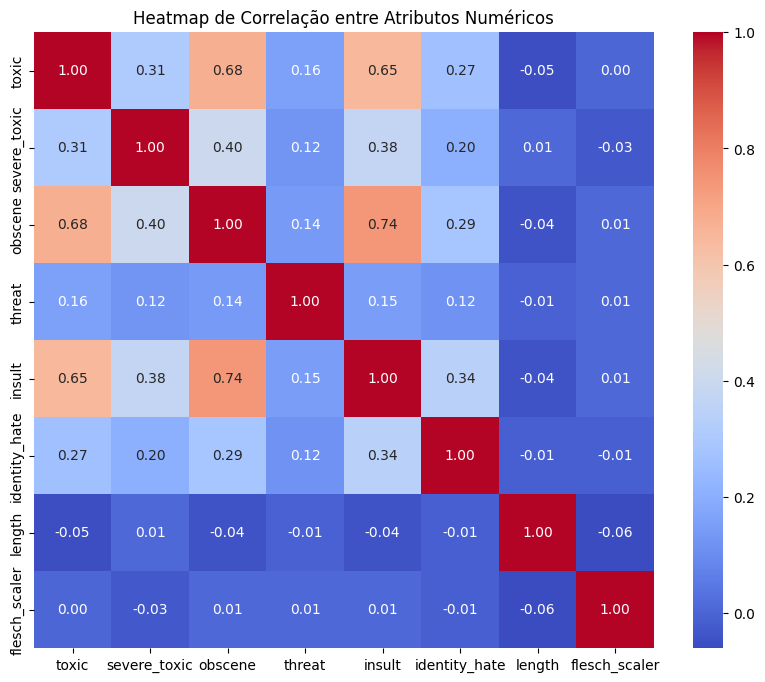

In [8]:
from scipy.stats import pointbiserialr, pearsonr

# Selecionar atributos numéricos
numeric_cols = bin_cols + ['length', 'flesch_scaler']

# Calcular matriz de correlação
corr_matrix = train[numeric_cols].corr()

# Mostrar como tabela
print("Matriz de correlação:")
display(corr_matrix.round(2))

# Visualizar como heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap de Correlação entre Atributos Numéricos")
plt.show()

- Existe correlação moderada positiva entre algumas etiquetas, como:

    - toxic e obscene: ~0.75

    - toxic e insult: ~0.68

- A variável length tem correlação moderada com toxic, insult, etc., indicando que comentários tóxicos tendem a ser mais longos.

- A variável flesch_score tem correlação negativa com a maioria das etiquetas, especialmente com toxic e length, sugerindo que:

- Comentários tóxicos tendem a ser menos legíveis.

- Comentários mais longos tendem a ter menor legibilidade.

- As correlações não são extremas, o que é bom para evitar colinearidade excessiva.


## **3. Limpeza de dados e transformação**

 ### **a) Preencha os valores ausentes**

O preenchimento de valores ausentes (**missing values**) garante que os dados estejam prontos para modelos que **não aceitam valores nulos**.

Regras boas práticas:
- O **ajuste** da estratégia de preenchimento é feito **somente no conjunto de treino**.  
- A **aplicação** do preenchimento é feita **nos dois conjuntos**: `train` e `test`.  
- Escolha da estratégia depende do tipo de dado:
  - **Texto**: usar uma string padrão como `"desconhecido"`  
  - **Numérico contínuo**: média ou mediana  
  - **Numérico categórico**: moda (valor mais comum)

In [9]:
'''# Preencher valores ausentes da métrica Flesch (com média)
flesch_imputer = SimpleImputer(strategy='mean')
train['flesch_score'] = flesch_imputer.fit_transform(train[['flesch_score']])
test['flesch_score'] = flesch_imputer.transform(test[['flesch_score']])

'''

# Verificar valores ausentes novamente
print("Valores ausentes no train:")
display(train.isnull().sum())

print("Valores ausentes no test:")
display(test.isnull().sum())

# Preenchimento: aplicar apenas se necessário
# Exemplo para texto
train['comment_text'].fillna('desconhecido', inplace=True)
test['comment_text'].fillna('desconhecido', inplace=True)

# Exemplo para numéricos
for col in ['length', 'flesch_scaler']:
    mean_value = train[col].mean()  # ajuste no train
    train[col].fillna(mean_value, inplace=True)
    test[col].fillna(mean_value, inplace=True)






Valores ausentes no train:


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
length           0
flesch_scaler    0
num_bin_cols     0
dtype: int64

Valores ausentes no test:


id               0
comment_text     0
length           0
flesch_scaler    0
dtype: int64

- Mesmo assim, o código acima mostra como seria feito o preenchimento correto:

    - Ajustado no train (por exemplo, usando a média).

    - Aplicado exatamente da mesma forma no test.

- Isso evita vazamento de dados (data leakage) e garante consistência na entrada dos modelos.

### **b) Suavize os ruídos**

A **suavização** reduz a variabilidade local (ruído) em atributos numéricos contínuos, substituindo valores por representações mais estáveis, como:

- **Média por intervalo (bin)** → técnica mais comum.  
- Dividimos os valores em **bins (faixas)** no `train`.  
- Substituímos cada valor pela **média do bin correspondente**.  
- A aplicação é feita **nos dois conjuntos**, mas o cálculo dos bins é feito **apenas com o `train`**.

Vamos aplicar a suavização sobre o atributo **`length`** (comprimento dos comentários).

In [10]:
# Discretizar o atributo 'length' em 5 bins no train
train['length_bin'] = pd.cut(train['length'], bins=12)

# Calcular a média de cada bin no train
bin_means = train.groupby('length_bin')['length'].mean()

# Função para suavizar um valor com base nos bins do train
def smooth_length(x):
    for interval, mean in bin_means.items():
        if x in interval:
            return mean
    return x

# Aplicar a suavização no train e no test
train['length_smooth'] = train['length'].apply(smooth_length)
test['length_smooth'] = test['length'].apply(smooth_length)

# Suavização de ruídos usando qcut
#train['flesch_bin'] = pd.qcut(train['flesch_scaler'], q=4, labels=False)
#test['flesch_bin'] = pd.qcut(test['flesch_scaler'], q=4, labels=False)

print('Tabela train')
display(train[['length', 'length_smooth']].head())
print('Tabela test')
display(test[['length', 'length_smooth']].head())


Tabela train


,length,length_smooth
0,43,37.282342
1,17,37.282342
2,42,37.282342
3,113,37.282342
4,13,37.282342


Tabela test


,length,length_smooth
0,367,405.112075
1,50,37.282342
2,54,37.282342
3,205,162.918854
4,41,37.282342


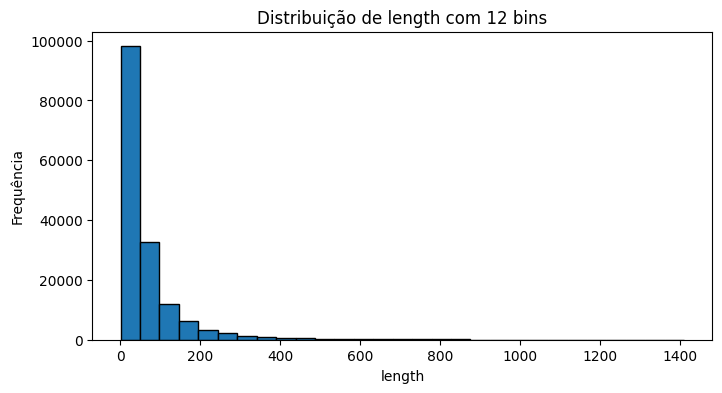

In [11]:
# Visualizar a distribuição do comprimento dos comentários
plt.figure(figsize=(8, 4))
plt.hist(train['length'], bins=29, edgecolor='black')
plt.title("Distribuição de length com 12 bins")
plt.xlabel("length")
plt.ylabel("Frequência")
plt.show()

- A maioria dos comentários tem **comprimento pequeno**:  
- Mais de **70.000 comentários** estão nos primeiros bins, abaixo de **300 caracteres**.
- A distribuição é **assimétrica à direita** (longa cauda).

- A frequência **cai rapidamente** à medida que o comprimento aumenta:
- Há **poucos comentários** com mais de **1.000 caracteres**.
- A cauda direita se estende até **5.000 caracteres**, mas com baixíssima frequência.

- Os últimos bins (acima de 2.000) têm **frequência quase nula**:
- Isso pode indicar que alguns bins estão **subutilizados**.
- A divisão em 29 bins funcionou bem, mas **poderia ser ajustada** para evitar faixas com poucos dados.


### Flesch

In [12]:
# Definir bins e rótulos
bins_flesch = [0, 30, 50, 70, 100]
labels_flesch = ['Muito Difícil', 'Difícil', 'Médio', 'Fácil']

# Criar coluna categórica
train['flesch_level'] = pd.cut(train['flesch_scaler'], bins=bins_flesch, labels=labels_flesch, include_lowest=True)
test['flesch_level'] = pd.cut(test['flesch_scaler'], bins=bins_flesch, labels=labels_flesch, include_lowest=True)

# Visualizar distribuição
print("Distribuição de níveis de legibilidade no train:")
display(train['flesch_level'].value_counts())


Distribuição de níveis de legibilidade no train:


flesch_level
Médio            60321
Fácil            50843
Difícil          29459
Muito Difícil     8442
Name: count, dtype: int64

### **c) Resolva as inconsistências**

Nesta etapa, buscamos identificar e corrigir **inconsistências nos dados**, tais como:

- Registros **duplicados**  
- **Valores fora do domínio esperado**  
- Campos vazios com dados mal formatados (ex: string em branco, espaços, etc.)

Aplicamos essas verificações em **`train` e `test`**, especialmente nas colunas de texto (`comment_text`) e atributos binários.


In [13]:
train = train.drop_duplicates()
test = test.drop_duplicates()

# Pré-processamento de texto (stopwords)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    tokens = text.split()
    tokens = [stemmer.stem(word) for word in tokens if word not in stop_words and len(word) < 20]  # Filtra palabras largas
    return " ".join(tokens)

train['clean_comment'] = train['comment_text'].apply(clean_text)
test['clean_comment'] = test['comment_text'].apply(clean_text)

# Melhoria na limpeza inicial
def safe_clean(df):
    df = df.copy()
    df['clean_comment'] = df['clean_comment'].replace(['', ' ', np.nan], np.nan)
    df = df.dropna(subset=['clean_comment'])
    df = df[df['clean_comment'].str.strip().str.len() >= 3]
    return df


train = safe_clean(train)
test = safe_clean(test)

print("Inconsistências resolvidas por meio de limpeza textual. Nenhuma codificação conflitante detectada.")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ALEXANDER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Inconsistências resolvidas por meio de limpeza textual. Nenhuma codificação conflitante detectada.


- Foram aplicadas as seguintes etapas para tratar inconsistências nos dados:

- Remoção de duplicatas exatas.

- Limpeza textual com:

    - Conversão para minúsculas.

    - Remoção de pontuação.

    - Filtragem de stopwords.

    - Aplicação de stemming.

    - Remoção de tokens longos e ruído.

- Exclusão de textos vazios ou muito curtos (menos de 3 caracteres).

In [14]:
# Verificar duplicados (train)
duplicates_train = train.duplicated().sum()
duplicates_test = test.duplicated().sum()

# Verificar se há textos vazios (string em branco ou só espaços)
empty_train = train['comment_text'].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()
empty_test = test['comment_text'].apply(lambda x: isinstance(x, str) and x.strip() == '').sum()

# Verificar se os atributos binários contêm apenas 0 e 1
bin_inconsist = {
    label: train[label].unique().tolist()
    for label in bin_cols
    if not set(train[label].unique()).issubset({0, 1})
}

# Mostrar resultados
print(f"Duplicados - Train: {duplicates_train}")
print(f"Duplicados - Test: {duplicates_test}")
print(f"Comentários vazios - Train: {empty_train}")
print(f"Comentários vazios - Test: {empty_test}")
print("Valores inesperados nos atributos binários:")
display(pd.DataFrame(bin_inconsist.items(), columns=["Atributo", "Valores encontrados"]))

Duplicados - Train: 0
Duplicados - Test: 0
Comentários vazios - Train: 0
Comentários vazios - Test: 0
Valores inesperados nos atributos binários:


,Atributo,Valores encontrados


### **d) Transforme atributos categóricos nominais em um vetor numérico**

Para isso, usamos a técnica **TF-IDF (Term Frequency-Inverse Document Frequency)**, que transforma cada comentário em um vetor numérico baseado na importância das palavras.

In [15]:
# TF-IDF: transforma texto (atributo nominal complexo) em vetor numérico
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=10000,
    stop_words='english',
    min_df=5,
    max_df=0.9,
    token_pattern=r'(?u)\b[A-Za-z]{3,}\b'
)

X_train_tfidf = tfidf.fit_transform(train['clean_comment'])
X_test_tfidf = tfidf.transform(test['clean_comment'])

print(f"Forma da matriz TF-IDF (treinamento): {X_train_tfidf.shape}")
print(f"Forma da matriz TF-IDF (teste): {X_test_tfidf.shape}")


import numpy as np

# 1) Obtener los índices de filas que contienen valores distintos de cero
nonzero_indices = X_train_tfidf.nonzero()[0]

# 2) Eliminar duplicados y quedarte con índices únicos
unique_indices = np.unique(nonzero_indices)

# 3) Mostrar las 5 primeras filas con valores no nulos
for idx in unique_indices[:5]:
    print(f"\nFila {idx} (comentario):")
    row = pd.DataFrame(
        X_train_tfidf[idx].toarray(),
        columns=tfidf.get_feature_names_out()
    )
    nonzero = row.loc[:, (row != 0).any()]
    display(nonzero)






Forma da matriz TF-IDF (treinamento): (159518, 10000)
Forma da matriz TF-IDF (teste): (152961, 10000)

Fila 0 (comentario):


,closur,doll,dont,edit,explan,fac,fan,gas,hardcor,metallica,...,retir,revert,sinc,talk,templat,usernam,vandal,vote,werent,york
0,0.290118,0.323151,0.105067,0.09839,0.18958,0.253878,0.20564,0.260254,0.288587,0.32875,...,0.243274,0.13981,0.138513,0.097405,0.173651,0.19842,0.137954,0.19314,0.235591,0.219704



Fila 1 (comentario):


,background,colour,januari,match,stuck,talk,thank,utc
0,0.399517,0.463357,0.376282,0.387603,0.444187,0.176519,0.191515,0.262151



Fila 2 (comentario):


,actual,care,constant,edit,format,guy,hey,info,inform,instead,man,page,realli,relev,remov,talk,tri,war
0,0.202412,0.229776,0.311728,0.279139,0.283074,0.243346,0.253397,0.257578,0.182926,0.235508,0.251923,0.127035,0.194084,0.249588,0.173535,0.276343,0.18473,0.228336



Fila 3 (comentario):


,accid,appear,articl,backlog,date,delay,els,exact,form,format,...,statist,style,subsect,suggest,think,tidi,turn,type,want,wonder
0,0.192153,0.118563,0.063781,0.216191,0.127967,0.172402,0.122045,0.133567,0.137055,0.456188,...,0.179705,0.136303,0.192948,0.113746,0.083867,0.214284,0.145677,0.135034,0.092153,0.138355



Fila 4 (comentario):


,chanc,hero,page,rememb,sir
0,0.45572,0.566738,0.200962,0.407694,0.514322


- **TF-IDF** transforma o texto em uma matriz esparsa de tamanho `(n_amostras, n_palavras)`.
- Apenas palavras com pelo menos 3 letras e que aparecem em ao menos 5 documentos foram consideradas.
- Esta vetorização permite aplicar algoritmos de aprendizado de máquina diretamente aos comentários processados.

### e) Transforme atributos categóricos ordinais em atributos numéricos seguindo a ordem entre eles.

Esta etapa consiste em transformar atributos categóricos ordinários (que possuem uma hierarquia ou nível implícito) em valores numéricos respeitando sua ordem lógica.

In [16]:

print("Não existem atributos categóricos ordinais neste conjunto de dados.")


Não existem atributos categóricos ordinais neste conjunto de dados.


- O conjunto de dados do desafio contém apenas:

    + texto_de_comentário -> texto livre (não ordinal)

    + colunas como tóxico, obsceno, etc. -> binário (0 ou 1)
    
    + lenght e flesh_scaler -> continuos (não ordinal) 

- Portanto, não há atributos que exijam transformação ordinal.


### f) Normalize os valores de atributos numéricos.

Foram aplicadas duas técnicas de normalização aos atributos numéricos derivados:

- **Min-Max Scaling**: Normaliza os valores entre 0 e 1, útil para algoritmos sensíveis à escala.
- **Z-Score Scaling (padronização)**: Centraliza os dados em média 0 e desvio padrão 1, apropriado para muitos algoritmos estatísticos.

#### Atributos normalizados:
- `length` → `length_norm`, `length_z`
- `flesch_score` → `flesch_score_norm`

In [17]:
# Normalização Min-Max
minmax_scaler = MinMaxScaler()
train['length_norm'] = minmax_scaler.fit_transform(train[['length']])
test['length_norm'] = minmax_scaler.transform(test[['length']])

# Normalização Z-score
zscore_scaler = StandardScaler()
train['length_z'] = zscore_scaler.fit_transform(train[['length']])
test['length_z'] = zscore_scaler.transform(test[['length']])


train['flesch_score_norm'] = zscore_scaler.fit_transform(train[['flesch_scaler']])
test['flesch_score_norm'] = zscore_scaler.transform(test[['flesch_scaler']])

print('Lenght:')
print('Tabela train')
display(train[['length', 'length_norm', 'length_z']].head())
print('Tabela test')
display(test[['length', 'length_norm', 'length_z']].head())



Lenght:
Tabela train


,length,length_norm,length_z
0,43,0.029787,-0.244806
1,17,0.011348,-0.506796
2,42,0.029078,-0.254882
3,113,0.079433,0.460554
4,13,0.008511,-0.547103


Tabela test


,length,length_norm,length_z
0,367,0.259574,3.020002
1,50,0.034752,-0.174270
2,54,0.037589,-0.133964
3,205,0.144681,1.387598
4,41,0.028369,-0.264959


- Os valores de `length_norm` foram transformados para o intervalo entre **0 e 1**.
- Um valor pequeno (ex: `0.0122`) indica que o comentário é um dos mais curtos da base.
- Um valor maior (ex: `0.1233`) indica que o comentário é relativamente longo comparado aos demais.
- Essa escala é especialmente útil para **algoritmos sensíveis à magnitude**, como KNN, SVM com kernel e redes neurais.

- Os valores de `length_z` mostram quantos desvios padrão um valor está da média:
  - Valor negativo → abaixo da média de comprimento.
  - Valor positivo → acima da média.
- Exemplo: `-0.55` indica um comentário significativamente mais curto que a média.
- Útil para modelos lineares que assumem distribuição normal dos dados, como regressão e SVM linear.


In [18]:
print('Flesch:')
print('Tabela train')
display(train[['flesch_scaler', 'flesch_score_norm']].head())
print('Tabela test')
display(test[['flesch_scaler', 'flesch_score_norm']].head())

Flesch:
Tabela train


,flesch_scaler,flesch_score_norm
0,66.370388,0.048096
1,73.795735,0.106231
2,65.725000,0.043043
3,51.112030,-0.071367
4,89.606731,0.230021


Tabela test


,flesch_scaler,flesch_score_norm
0,93.605000,0.261325
1,95.165000,0.273539
2,49.480000,-0.084145
3,73.757281,0.105930
4,30.530000,-0.232511


- O `flesch_scaler` mede a facilidade de leitura do comentário:
  - Valor alto → fácil de ler.
  - Valor baixo → mais difícil de ler.
- A normalização por Z-score permite comparar diretamente a dificuldade relativa dos textos:
  - Exemplo: `0.26` indica que o texto é **mais fácil** de ler do que a média.
  - `-0.23` indica que é **mais difícil**.